In [1]:
import numpy as truenp

import matplotlib.pyplot as plt
import matplotlib.cm as color
better_magma = color.magma
better_magma.set_bad('black',1.)
import matplotlib.colors as c

from prysm import (
    mathops, 
    conf,
)
from prysm.mathops import (
    np,
    fft,
    interpolate,
    ndimage,
)
from prysm.coordinates import (
    make_xy_grid, 
    cart_to_polar,
)
from prysm.propagation import Wavefront as WF
from prysm.propagation import (
    focus_fixed_sampling,
    focus_fixed_sampling_backprop
)                              
from prysm.thinlens import (
    defocus_to_image_displacement,
    image_displacement_to_defocus,
)
from prysm.geometry import (
    circle,
    spider,
)
from prysm.polynomials import (
    lstsq,
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes,
    sum_of_2d_modes_backprop
)
mathops.set_backend_to_cupy()

from utils import generate_freqs, kneePSD, generate_time_series, ensure_np, save_pickle

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data = {'f_max' : 1,         # hz
        't_max' : 10 * 3600, # sec
        'f_knee' : 1 / (2 * 3600), # hz
        'slope' : 6,
        'freqs' : [],
        'psd' : [],
        'times' : [],
        'DOF' : {'M1_dx' : {'RMS' : 10e-6, 'timeseries' : []},
                 'M1_dy' : {'RMS' : 10e-6, 'timeseries' : []},
                 'M1_dz' : {'RMS' : 10e-6, 'timeseries' : []},
                 'M1_tx' : {'RMS' : 5e-6, 'timeseries' : []},
                 'M1_ty' : {'RMS' : 5e-6, 'timeseries' : []},
                 'M2_dx' : {'RMS' : 10e-6, 'timeseries' : []},
                 'M2_dy' : {'RMS' : 10e-6, 'timeseries' : []},
                 'M2_dz' : {'RMS' : 10e-6, 'timeseries' : []},
                 'M2_tx' : {'RMS' : 5e-6, 'timeseries' : []},
                 'M2_ty' : {'RMS' : 5e-6, 'timeseries' : []},}}

In [3]:
f_max = data['f_max']
t_max = data['t_max']
f_knee = data['f_knee']
slope = data['slope']

freqs, times = generate_freqs(Nf=2**18+1, f_max=f_max)
psd = kneePSD(freqs, 1, f_knee, slope)

for i, key in enumerate(data['DOF']):
    rms = data['DOF'][key]['RMS']
    timeseries = generate_time_series(psd, f_max, rms=rms, seed=727 + i)

    timeseries -= timeseries[0]
    timeseries = timeseries[times < t_max]
    timeseries *= rms / np.sqrt(np.mean(timeseries ** 2))

    data['DOF'][key]['timeseries'] = ensure_np(timeseries)

times = times[times < t_max]

data['times'] = ensure_np(times)
data['freqs'] = ensure_np(freqs)
data['psd'] = ensure_np(psd)

interval = float(times[1] - times[0])
print(interval)

0.5


(array([1.e-28, 1.e-25, 1.e-22, 1.e-19, 1.e-16, 1.e-13, 1.e-10, 1.e-07,
        1.e-04, 1.e-01, 1.e+02, 1.e+05]),
 [Text(0, 1e-28, '$\\mathdefault{10^{-28}}$'),
  Text(0, 1e-25, '$\\mathdefault{10^{-25}}$'),
  Text(0, 1e-22, '$\\mathdefault{10^{-22}}$'),
  Text(0, 1e-19, '$\\mathdefault{10^{-19}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-13, '$\\mathdefault{10^{-13}}$'),
  Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'),
  Text(0, 1e-07, '$\\mathdefault{10^{-7}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$')])

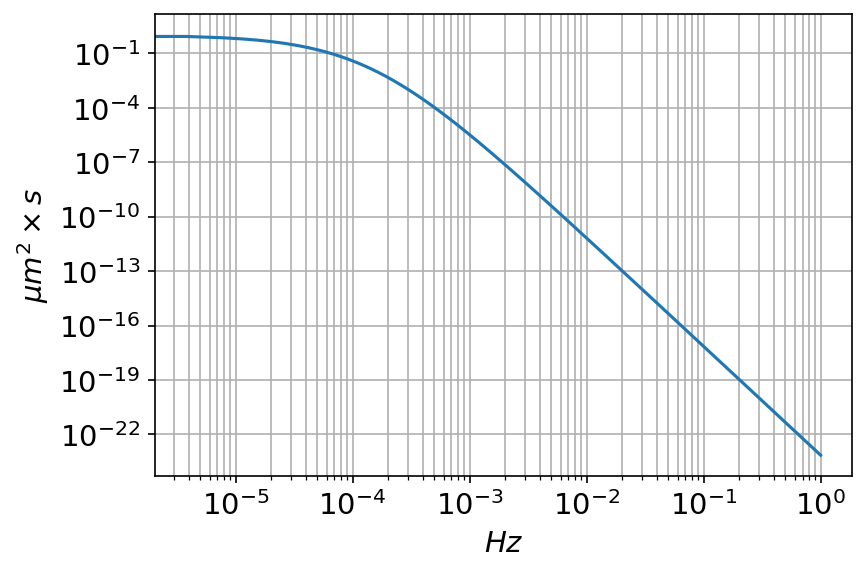

In [15]:
plt.figure(figsize=(6, 4), dpi=150)
plt.loglog(data['freqs'], data['psd'])
plt.ylabel(r'$\mu m^2 \times s$', fontsize=14)
plt.xlabel(r'$Hz$', fontsize=14)
plt.grid(which='both')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


(array([-12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,
         10. ]),
 [Text(0, -12.5, '−12.5'),
  Text(0, -10.0, '−10.0'),
  Text(0, -7.5, '−7.5'),
  Text(0, -5.0, '−5.0'),
  Text(0, -2.5, '−2.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0')])

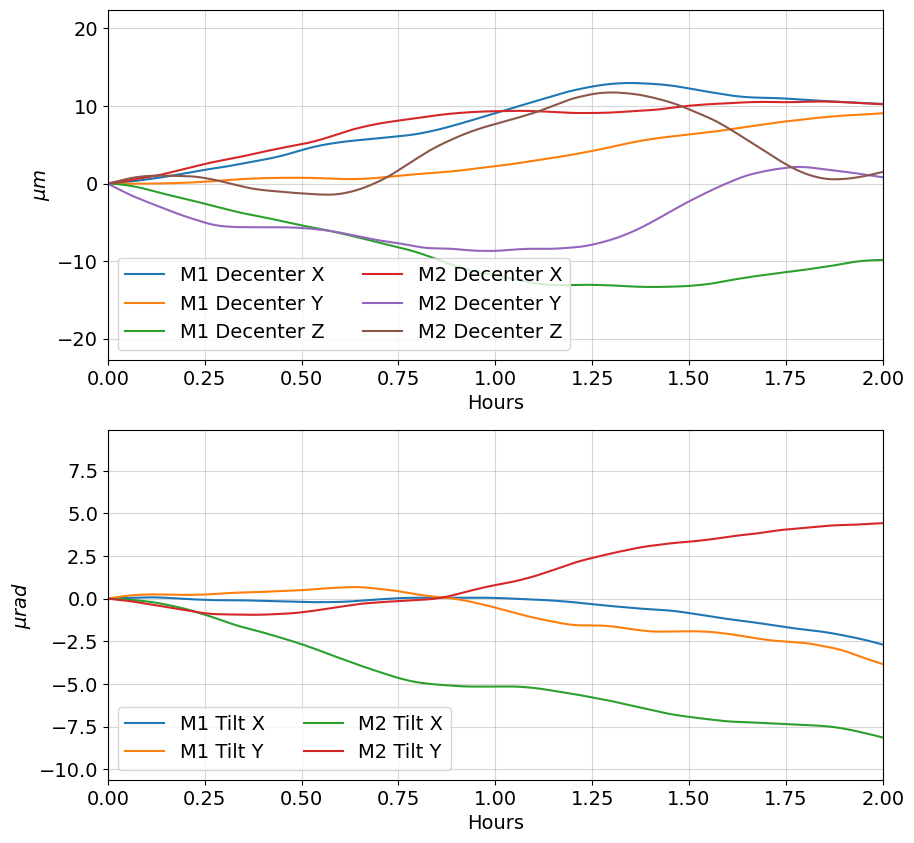

In [14]:
labels = ['M1 Decenter X', 'M1 Decenter Y', 'M1 Decenter Z', 'M2 Decenter X', 'M2 Decenter Y', 'M2 Decenter Z']

plt.figure(figsize=(10, 10))
plt.subplot(211)
count = 0
for i, key in enumerate(data['DOF']):
    if 'd' in key:
        plt.plot(data['times'] / 3600, data['DOF'][key]['timeseries'] * 1e6, label=labels[count])
        count += 1
plt.legend(ncols=2, fontsize=14)
plt.xlabel('Hours', fontsize=14)
plt.ylabel(r'$\mu m$', fontsize=14)
plt.xlim([0, 2])
plt.grid(alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

labels = ['M1 Tilt X', 'M1 Tilt Y', 'M2 Tilt X', 'M2 Tilt Y']

plt.subplot(212)
count = 0
for i, key in enumerate(data['DOF']):
    if 't' in key:
        plt.plot(data['times'] / 3600, data['DOF'][key]['timeseries'] * 1e6, label=labels[count])
        count += 1
plt.legend(ncols=2, fontsize=14, loc='lower left')
plt.xlabel('Hours', fontsize=14)
plt.ylabel(r'$\mu rad$', fontsize=14)
plt.xlim([0, 2])
plt.grid(alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [8]:
save_pickle('/home/derbyk/src/ffpr/data/timeseries_data.pkl', data=data)

Saved data to:  /home/derbyk/src/ffpr/data/timeseries_data.pkl
